0.023799785336203427 arcsec
DEBUG:poppy:Skipping oversampling, oversample < 1 or already padded 


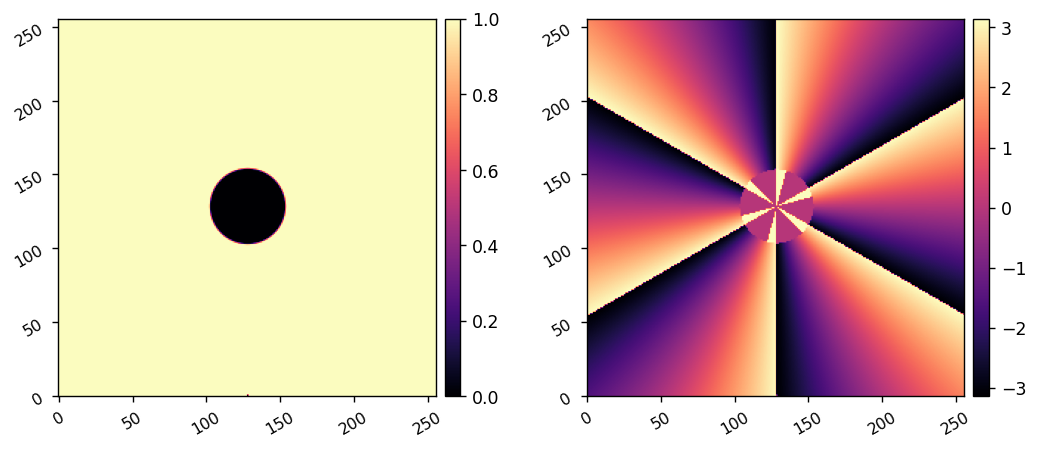

In [8]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

from prop_models import coro, coro2, agpm
import misc_funs as misc
reload(coro)
reload(coro2)
reload(agpm)
reload(misc)

diam = 6.5*u.m
wavelength_c = 750e-9*u.m
as_per_lamd = (wavelength_c/diam *u.radian).to(u.arcsec)
print(as_per_lamd)

lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3.65*u.mm/2, gray_pixel=False)

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
wave = poppy.FresnelWavefront(wavelength=wavelength_c, beam_radius=50*u.um, npix=256, oversample=1)
vvc_phasor = vortex.get_phasor(wave)
misc.imshow2(np.abs(vvc_phasor), np.angle(vvc_phasor))

0.0011899892668101714 arcsec


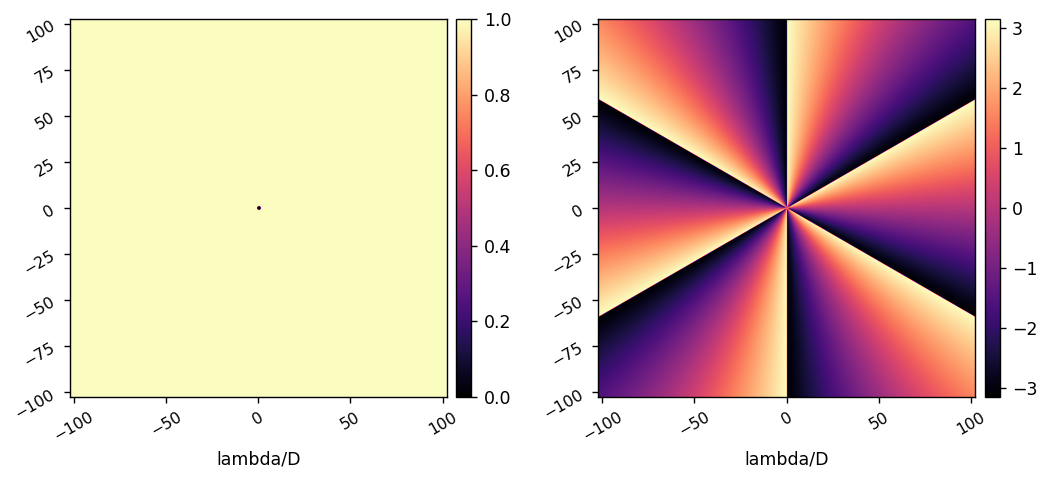

Saved data to:  fpm_0.05lamD_amp.fits
Saved data to:  fpm_0.05lamD_opd.fits
DEBUG:poppy:Trans: fpm_0.05lamD_amp.fits
DEBUG:poppy:OPD: fpm_0.05lamD_opd.fits
INFO:poppy:FPM: Loaded amplitude transmission from fpm_0.05lamD_amp.fits
INFO:poppy:FPM: Loaded OPD from fpm_0.05lamD_opd.fits
DEBUG:poppy:FixedSamplingImagePlaneElement FPM initialized:centering style ADJUSTABLE, central wavelength for operation 7.5e-07 m, entrance pupil diameter of system 6.5 m, pixelscale of 0.001189989266810171 arcsec/pix.


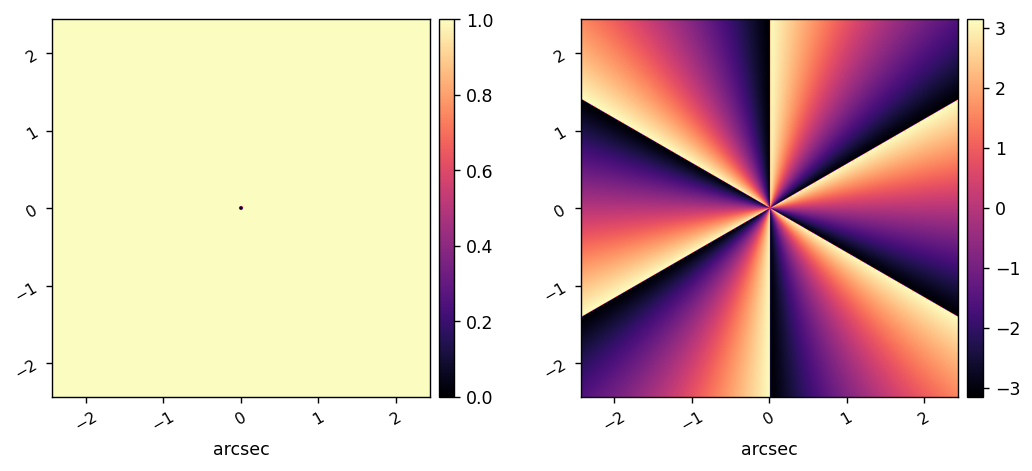

In [9]:
n = 4096
pxscl = 0.05
pxscl_as = pxscl*as_per_lamd
print(pxscl_as)

xfp = pxscl*(np.linspace(-n//2, n//2-1, n) + 1/2)
fpx, fpy = np.meshgrid(xfp,xfp)
rfp = np.sqrt(fpx**2 + fpy**2)
phase = np.arctan2(fpy,fpx)

charge = 6

fpm_amp = np.float64((rfp>1))
fpm_opd = charge * phase * wavelength_c.value/ (2 * np.pi)
fpm = fpm_amp * np.exp(1j* 2*np.pi/wavelength_c.value *fpm_opd)

misc.imshow2(abs(fpm), np.angle(fpm),
             pxscl1=pxscl, pxscl2=pxscl)

header={'WAVELENC':750e-9, 'PUPLDIAM':6.5, 'PIXSCLLD':0.05, 'PIXELSCL':pxscl_as.value}
misc.save_fits('fpm_0.05lamD_amp.fits', data=fpm_amp, header=header)
misc.save_fits('fpm_0.05lamD_opd.fits', data=fpm_opd, header=header)

FPM = poppy.FixedSamplingImagePlaneElement('FPM', 
                                           transmission='fpm_0.05lamD_amp.fits', 
                                           opd='fpm_0.05lamD_opd.fits', opdunits='meters',
                                          )
misc.imshow2(FPM.amplitude, np.angle(np.exp(1j*FPM.opd*2*np.pi/wavelength_c.value)), 
             pxscl1=FPM.pixelscale, pxscl2=FPM.pixelscale)


In [17]:
reload(coro)
poppy_log.disabled = True

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)

c = coro.CORO(dm_inf='inf.fits',
              npix=512,
              oversample=4,
              LYOT=lyot_stop,
             )

c = coro.CORO(dm_inf='inf.fits',
              npix=128,
              oversample=16,
              LYOT=lyot_stop,
             )

Propagating wavelength 750.000 nm.
PSF calculated in 1.799s


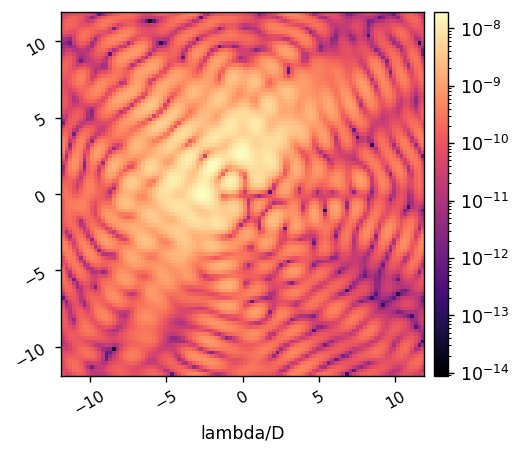

In [21]:
# c.FPM = FPM
psf = c.calc_psf(quiet=False)
misc.imshow1(abs(psf)**2, lognorm=True, pxscl=c.psf_pixelscale_lamD)

Propagating wavelength 750.000 nm.
PSF calculated in 0.598s


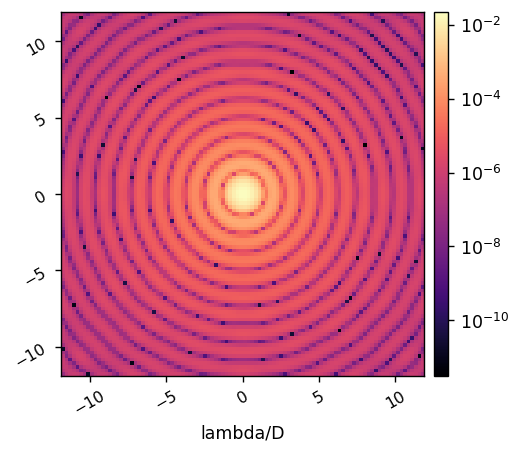

Propagating wavelength 750.000 nm.
PSF calculated in 0.394s


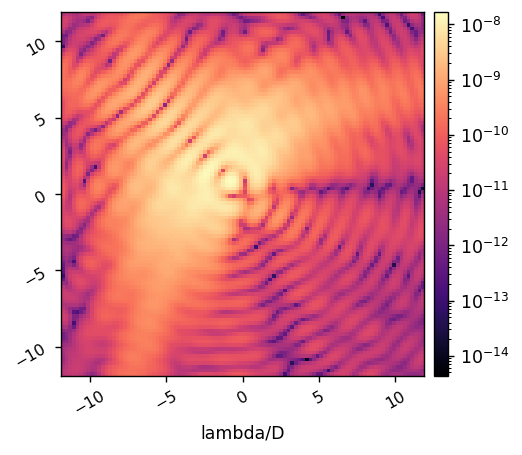

Propagating wavelength 750.000 nm.
PSF calculated in 1.831s


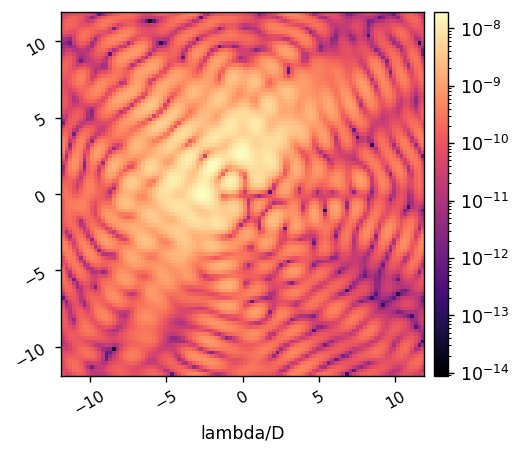

In [18]:
poppy_log.disabled = True
c.FPM = None
psf = c.calc_psf(quiet=False)
misc.imshow1(abs(psf)**2, lognorm=True, pxscl=c.psf_pixelscale_lamD)

c.FPM = vortex
psf = c.calc_psf(quiet=False)
misc.imshow1(abs(psf)**2, lognorm=True, pxscl=c.psf_pixelscale_lamD)

c.FPM = FPM
psf = c.calc_psf(quiet=False)
misc.imshow1(abs(psf)**2, lognorm=True, pxscl=c.psf_pixelscale_lamD)

In [152]:
poppy_log.disabled = False
wfs = c.calc_wfs()

Propagating wavelength 750.000 nm.
DEBUG:poppy:Initialized: OAP1, fl =2.00e-01 m
DEBUG:poppy:Initialized: OAP2, fl =2.00e-01 m
DEBUG:poppy:Initialized: OAP3, fl =5.00e-01 m
DEBUG:poppy:Initialized: OAP4, fl =3.50e-01 m
DEBUG:poppy:Initialized: OAP5, fl =2.00e-01 m
INFO:poppy:Initialized OpticalSystem: unnamed system
INFO:poppy:Added optic: Circle, radius=5.1 mm after separation: 0.00e+00 m 
INFO:poppy:Added optic: DM after separation: 0.00e+00 m 
INFO:poppy:Added optic: OAP1 after separation: 2.00e+02 mm 
INFO:poppy:Added optic: Circle, radius=6.35 mm after separation: 0.00e+00 m 
INFO:poppy:Added optic: Int Focal Plane after separation: 2.00e+02 mm 
INFO:poppy:Added optic: OAP2 after separation: 2.00e+02 mm 
INFO:poppy:Added optic: Circle, radius=6.35 mm after separation: 0.00e+00 m 
INFO:poppy:Added optic: Apodizer Place-holder after separation: 2.00e+02 mm 
INFO:poppy:Added optic: OAP3 after separation: 5.00e+02 mm 
INFO:poppy:Added optic: Circle, radius=6.35 mm after separation: 0.

DEBUG:poppy:  Multiplied WF by phasor for Optic: Apodizer Place-holder
DEBUG:poppy:  Propagating wavefront to Lens: OAP3, with focal length 0.5 m after distance 0.5 m 
DEBUG:poppy:Beginning Fresnel Prop. Waist at z = 1.0000000000219247 m
DEBUG:poppy:  Plane to Plane Regime, dz=0.5 m
DEBUG:poppy:  Constant Pixelscale: 9.961004631963875e-06 m / pix
DEBUG:poppy:using cupy (GPU) FFT of (2048, 2048) array, FFT_direction=forward
DEBUG:poppy:    FFT_2D: FFT in 0.000000 s, full function  in 0.000 s
DEBUG:poppy:using cupy (GPU) FFT of (2048, 2048) array, FFT_direction=backward
DEBUG:poppy:    FFT_2D: FFT in 0.000000 s, full function  in 0.000 s
DEBUG:poppy:------ Propagated to plane of type PlaneType.intermediate at z = 1.30e+00 m ------
DEBUG:poppy:------ Applying Lens: OAP3 ------
DEBUG:poppy:  Pre-Lens Beam Parameters: w_0:5.100e-03 m, z_w0=1.000e+00 m
z=1.300e+00 m, z_r=1.090e+02 m
DEBUG:poppy:  Beam radius at OAP3 =5.10e-03 m
DEBUG:poppy: input flat wavefront and OAP3 has output beam curva

DEBUG:poppy:Magnification: -0.0  from R_in = inf m, R_out = -0.2 m
DEBUG:poppy:Output beam focal length is now 0.0 m
DEBUG:poppy:Inside Rayleigh distance to Outside Rayleigh distance.
DEBUG:poppy:Applying spherical phase curvature =1.43e+04 m
DEBUG:poppy:Applying spherical lens phase =7.02e-05 1 / m
DEBUG:poppy:  Multiplied WF by phasor for Optic: OAP5
DEBUG:poppy:------ Optic: OAP5 applied ------
DEBUG:poppy:  Propagating wavefront to Optic: Circle, radius=6.35 mm after distance 0.0 m 
DEBUG:poppy:  Multiplied WF by phasor for Optic: Circle, radius=6.35 mm
DEBUG:poppy:  Propagating wavefront to Optic: Image Plane after distance 0.2 m 
DEBUG:poppy:Beginning Fresnel Prop. Waist at z = 2.8999971931210786 m
DEBUG:poppy:  Spherical to Plane Regime, outside Z_R to inside Z_R
DEBUG:poppy:Spherical to Waist propagation, dz=0.19999719312107844 m
DEBUG:poppy:using cupy (GPU) FFT of (2048, 2048) array, FFT_direction=backward
DEBUG:poppy:    FFT_2D: FFT in 0.000000 s, full function  in 0.000 s
DE

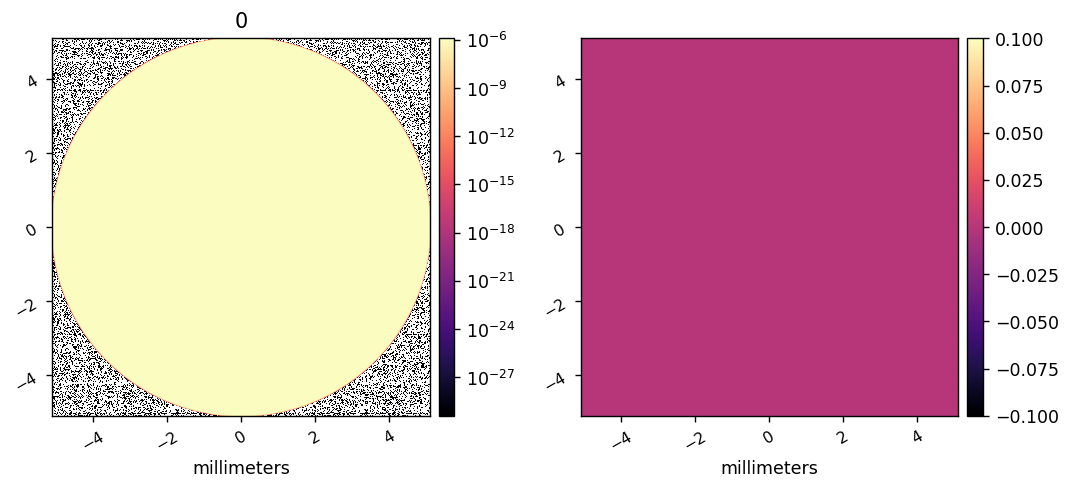

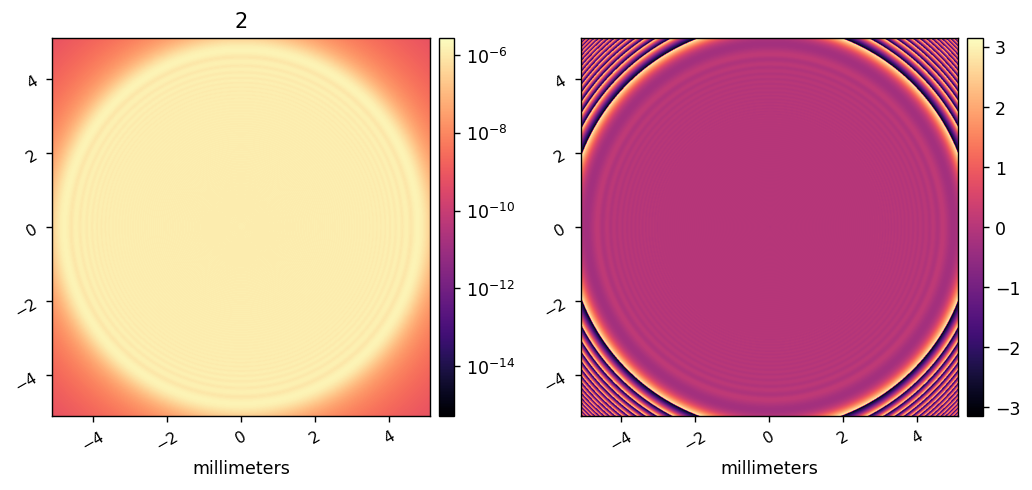

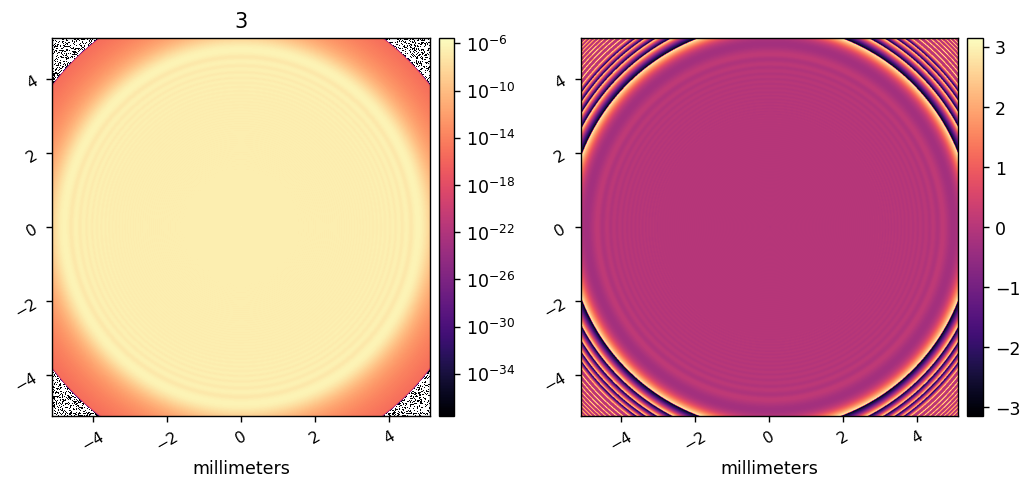

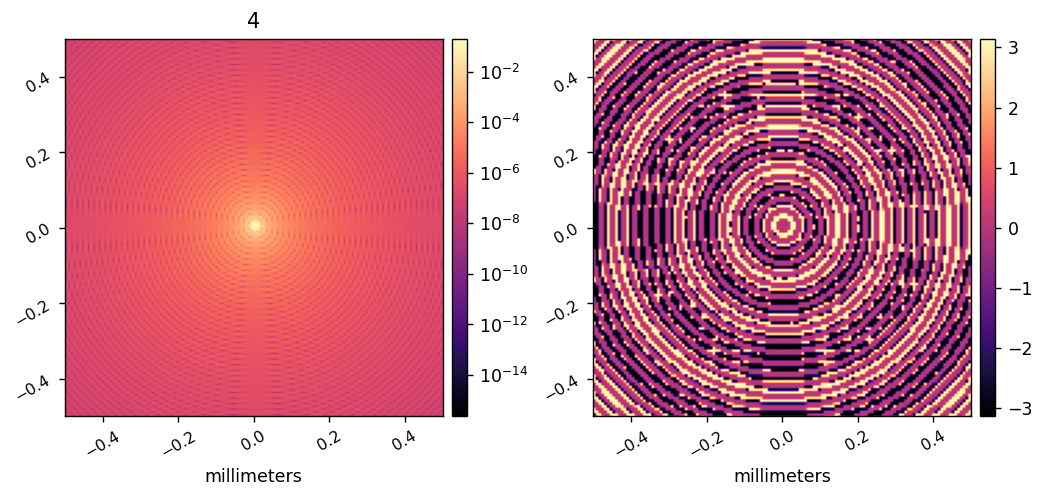

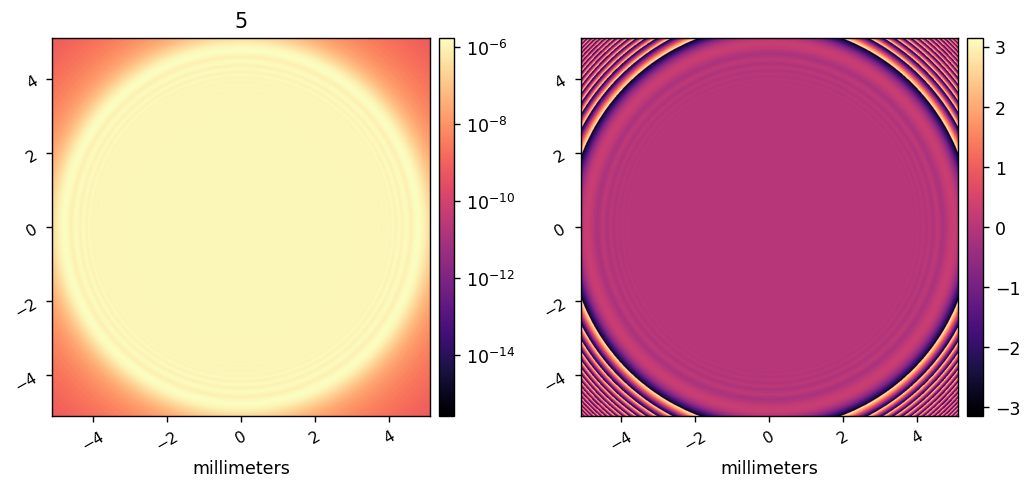

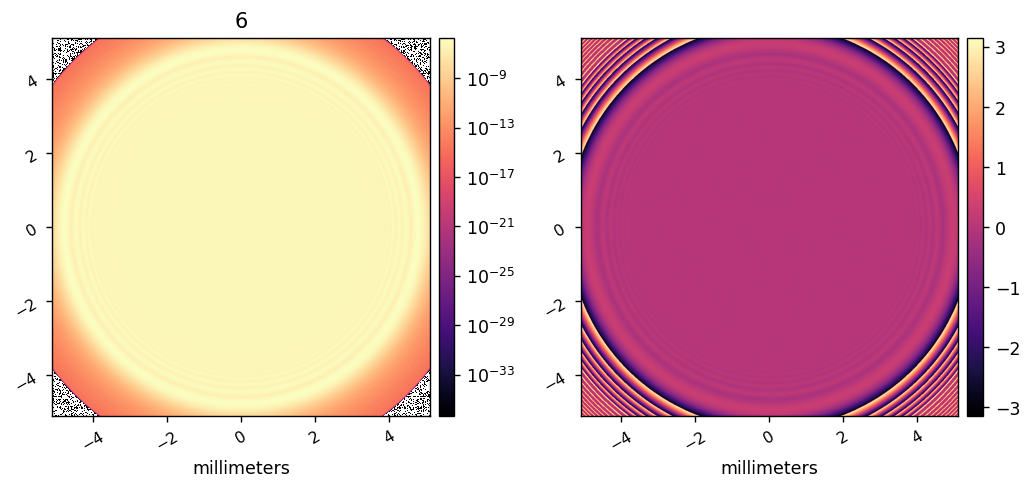

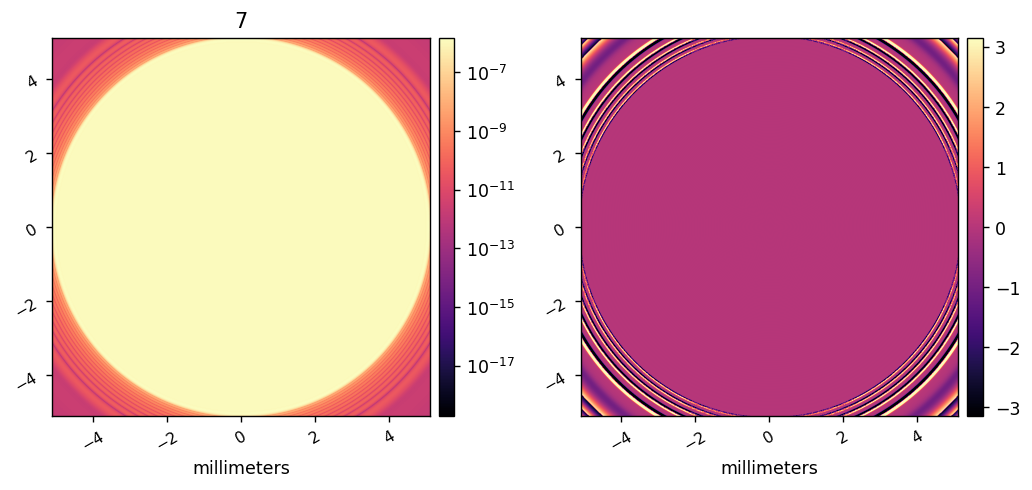

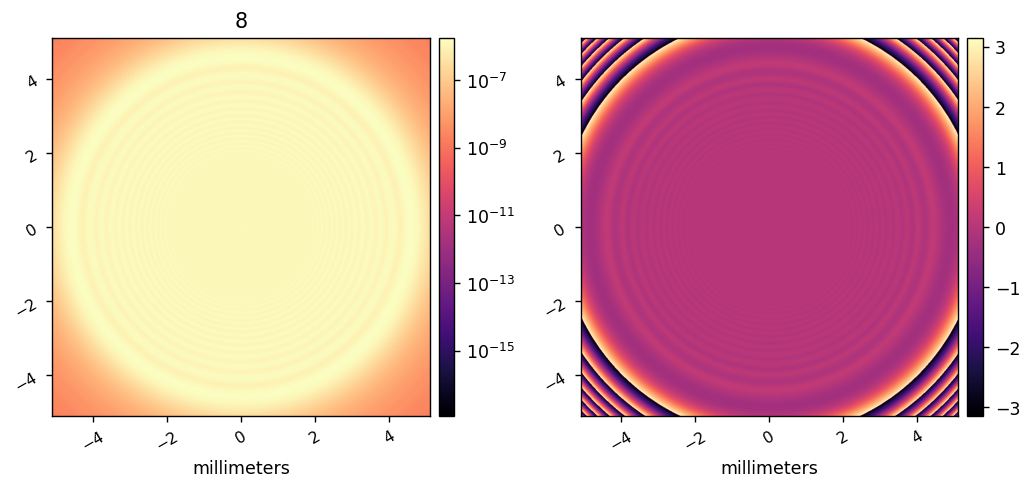

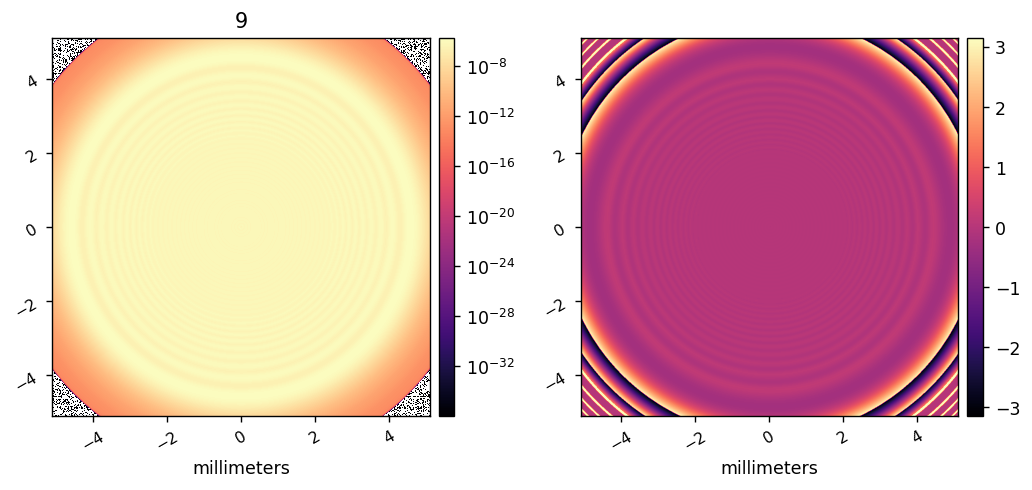

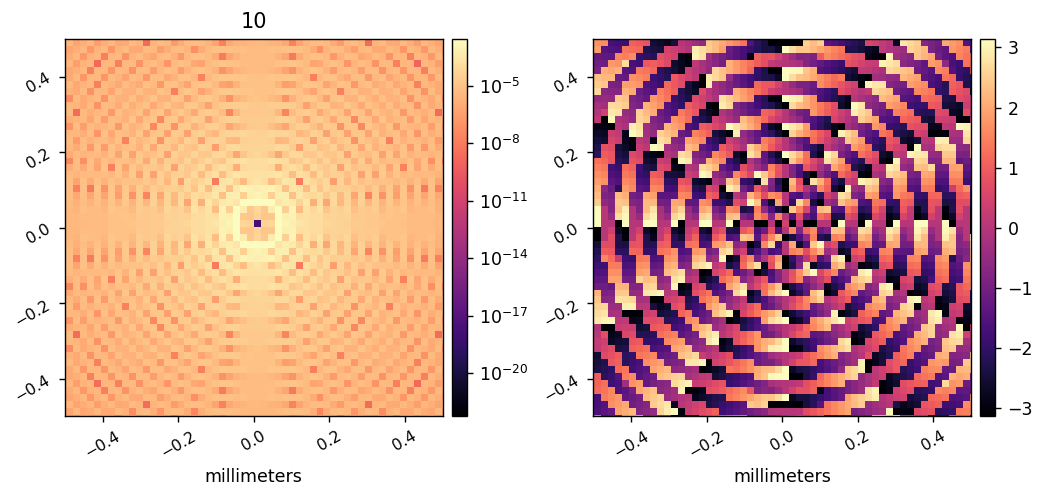

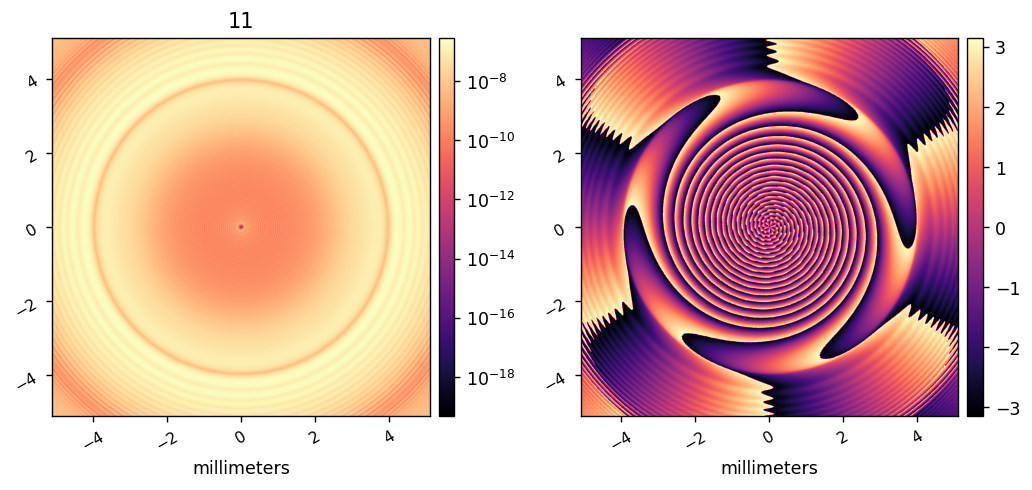

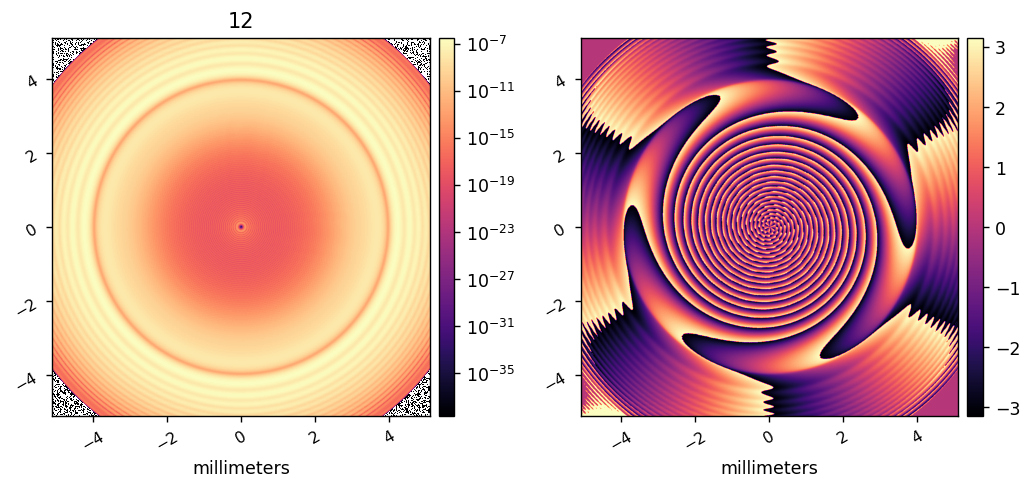

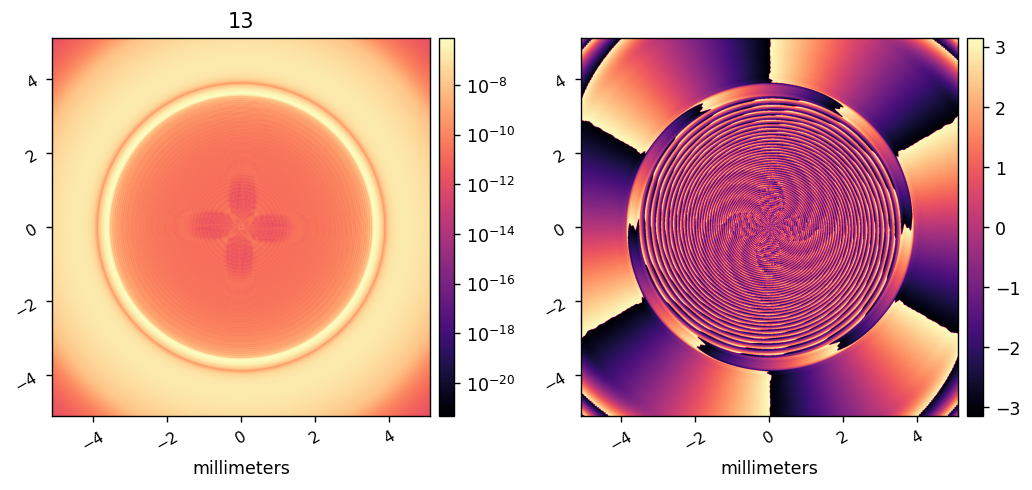

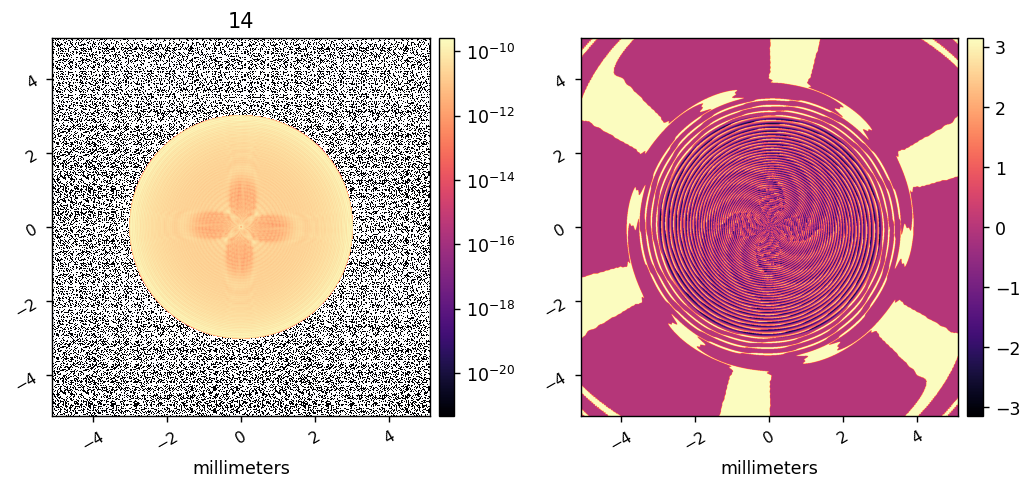

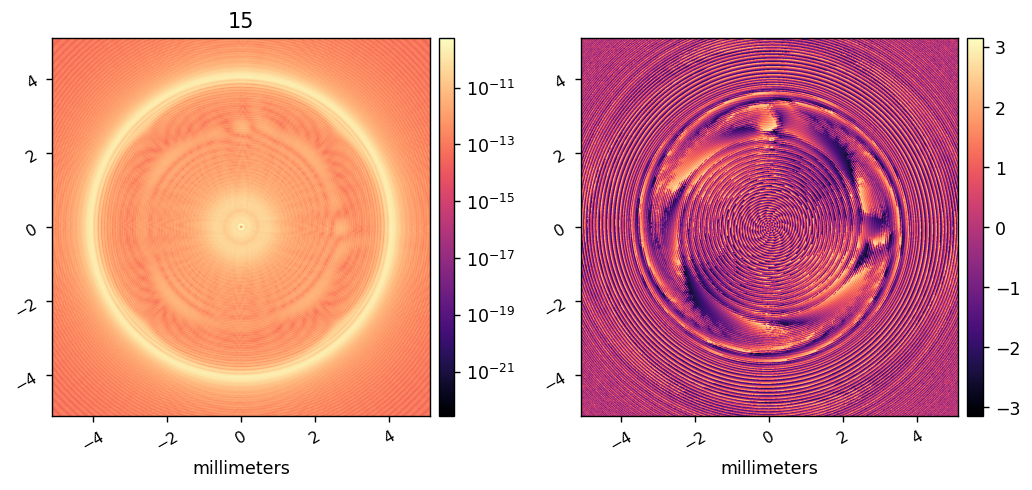

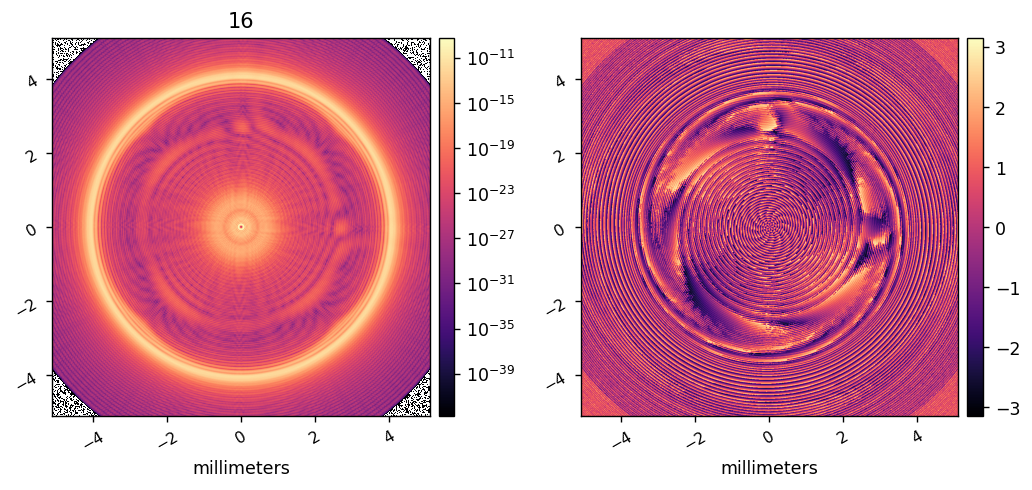

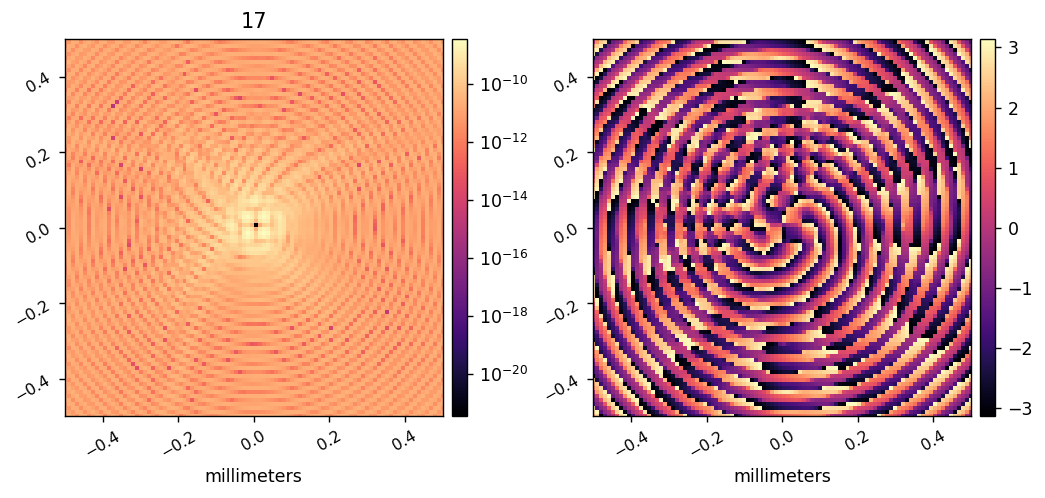

In [153]:
from IPython.display import display

pupil_lim = c.pupil_diam.value/2
fp_lim = 1/2

for i,wf in enumerate(wfs):
    fig, ax = misc.imshow2(wf.intensity, wf.phase, '{:d}'.format(i), 
                           pxscl1=wf.pixelscale.to(u.mm/u.pix), pxscl2=wf.pixelscale.to(u.mm/u.pix),
                           lognorm1=True,
                           display_fig=False, return_fig=True)
    if i in [c.inter_fp_index, c.fpm_index, c.image_index]:
        ax[0].set_xlim([-fp_lim, fp_lim])
        ax[0].set_ylim([-fp_lim, fp_lim])
        ax[1].set_xlim([-fp_lim, fp_lim])
        ax[1].set_ylim([-fp_lim, fp_lim])
    else:
        ax[0].set_xlim([-pupil_lim, pupil_lim])
        ax[0].set_ylim([-pupil_lim, pupil_lim])
        ax[1].set_xlim([-pupil_lim, pupil_lim])
        ax[1].set_ylim([-pupil_lim, pupil_lim])
    display(fig)